# Comprehensive EDA for Protein Secondary Structure Prediction

This notebook provides a thorough exploratory data analysis for the protein secondary structure
prediction (SSP) dataset, covering both SST8 (8-class) and SST3 (3-class) classification schemes.

## Contents
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Basic Dataset Statistics](#2-basic-dataset-statistics)
3. [Sequence Analysis](#3-sequence-analysis)
4. [SST8 Secondary Structure Analysis](#4-sst8-secondary-structure-analysis)
5. [SST3 Secondary Structure Analysis](#5-sst3-secondary-structure-analysis)
6. [Sequence-Structure Relationships](#6-sequence-structure-relationships)
7. [Data Leakage Analysis](#7-data-leakage-analysis)
8. [Summary & Recommendations](#8-summary--recommendations)

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import Dict, List, Tuple
import hashlib
import warnings

warnings.filterwarnings('ignore')

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [2]:
# Load datasets
DATA_DIR = "../../data"

train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

print("✅ Data loaded successfully!")
print(f"   Train: {len(train_df):,} samples")
print(f"   Test:  {len(test_df):,} samples")

✅ Data loaded successfully!
   Train: 7,262 samples
   Test:  1,816 samples


## 2. Basic Dataset Statistics

In [3]:
print("=" * 60)
print("TRAINING DATA INFO")
print("=" * 60)
print(f"\nShape: {train_df.shape}")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nData Types:\n{train_df.dtypes}")
print(f"\nMemory Usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

TRAINING DATA INFO

Shape: (7262, 4)

Columns: ['id', 'seq', 'sst8', 'sst3']

Data Types:
id       int64
seq     object
sst8    object
sst3    object
dtype: object

Memory Usage: 6.12 MB


In [4]:
print("=" * 60)
print("TEST DATA INFO")
print("=" * 60)
print(f"\nShape: {test_df.shape}")
print(f"\nColumns: {list(test_df.columns)}")
print(f"\nData Types:\n{test_df.dtypes}")
print(f"\nMemory Usage: {test_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

TEST DATA INFO

Shape: (1816, 2)

Columns: ['id', 'seq']

Data Types:
id      int64
seq    object
dtype: object

Memory Usage: 0.52 MB


In [5]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)
print("\nTraining Data Missing Values:")
print(train_df.isnull().sum())
print("\nTest Data Missing Values:")
print(test_df.isnull().sum())

# Validate that sequence length matches label lengths
train_df['seq_len'] = train_df['seq'].str.len()
train_df['sst8_len'] = train_df['sst8'].str.len()
train_df['sst3_len'] = train_df['sst3'].str.len()

length_mismatch = train_df[(train_df['seq_len'] != train_df['sst8_len']) | 
                           (train_df['seq_len'] != train_df['sst3_len'])]

print(f"\n⚠️  Sequences with length mismatch (seq vs labels): {len(length_mismatch)}")
if len(length_mismatch) > 0:
    print(length_mismatch[['id', 'seq_len', 'sst8_len', 'sst3_len']].head())

MISSING VALUES ANALYSIS

Training Data Missing Values:
id      0
seq     0
sst8    0
sst3    0
dtype: int64

Test Data Missing Values:
id     0
seq    0
dtype: int64

⚠️  Sequences with length mismatch (seq vs labels): 0


In [6]:
# Sample data preview
print("=" * 60)
print("SAMPLE DATA PREVIEW")
print("=" * 60)
print("\nTraining Data (first 3 rows):")
for i, row in train_df.head(3).iterrows():
    print(f"\n[{row['id']}] Sequence length: {len(row['seq'])}")
    print(f"  SEQ:  {row['seq'][:60]}...")
    print(f"  SST8: {row['sst8'][:60]}...")
    print(f"  SST3: {row['sst3'][:60]}...")

SAMPLE DATA PREVIEW

Training Data (first 3 rows):

[0] Sequence length: 27
  SEQ:  GVGLEGGVQLSPARTRGPEFAAPEQAG...
  SST8: CCCCCCCCSCCCCCCGGGCCCCCCCCC...
  SST3: CCCCCCCCCCCCCCCHHHCCCCCCCCC...

[1] Sequence length: 292
  SEQ:  NHGKVKIEHTKWNVEYKVTYNRNVFANHIRSGELASNGYHTTRRTAHTVDMNRGYTIEFE...
  SST8: CEEEEEECCTTTEEEEEEEEEEEEEEEEEEEEECSCCSSSCCCCEEEEEEEEEEEEEEEE...
  SST3: CEEEEEECCCCCEEEEEEEEEEEEEEEEEEEEECCCCCCCCCCCEEEEEEEEEEEEEEEE...

[2] Sequence length: 193
  SEQ:  EMRKMLADWKGLSKSDGMLSSEGRTKALWLGEANFSYVPKLDPRASAKLIKSELSDLILP...
  SST8: CTHHHHHHHHHSGGGCCCCCCCCCCCCEEECSSCEEEEEEETTCGGGEECSSCSSCEEEC...
  SST3: CCHHHHHHHHHCHHHCCCCCCCCCCCCEEECCCCEEEEEEECCCHHHEECCCCCCCEEEC...


## 3. Sequence Analysis

### 3.1 Sequence Length Distribution

In [7]:
# Add sequence length to test data
test_df['seq_len'] = test_df['seq'].str.len()

# Statistics
train_stats = train_df['seq_len'].describe()
test_stats = test_df['seq_len'].describe()

print("=" * 60)
print("SEQUENCE LENGTH STATISTICS")
print("=" * 60)
print("\n{:<15} {:>12} {:>12}".format("Statistic", "Train", "Test"))
print("-" * 40)
for stat in ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    print("{:<15} {:>12.1f} {:>12.1f}".format(stat, train_stats[stat], test_stats[stat]))

SEQUENCE LENGTH STATISTICS

Statistic              Train         Test
----------------------------------------
count                 7262.0       1816.0
mean                   242.9        244.3
std                    157.3        153.6
min                     20.0         20.0
25%                    131.0        133.0
50%                    207.0        215.0
75%                    324.0        320.0
max                   1632.0       1174.0


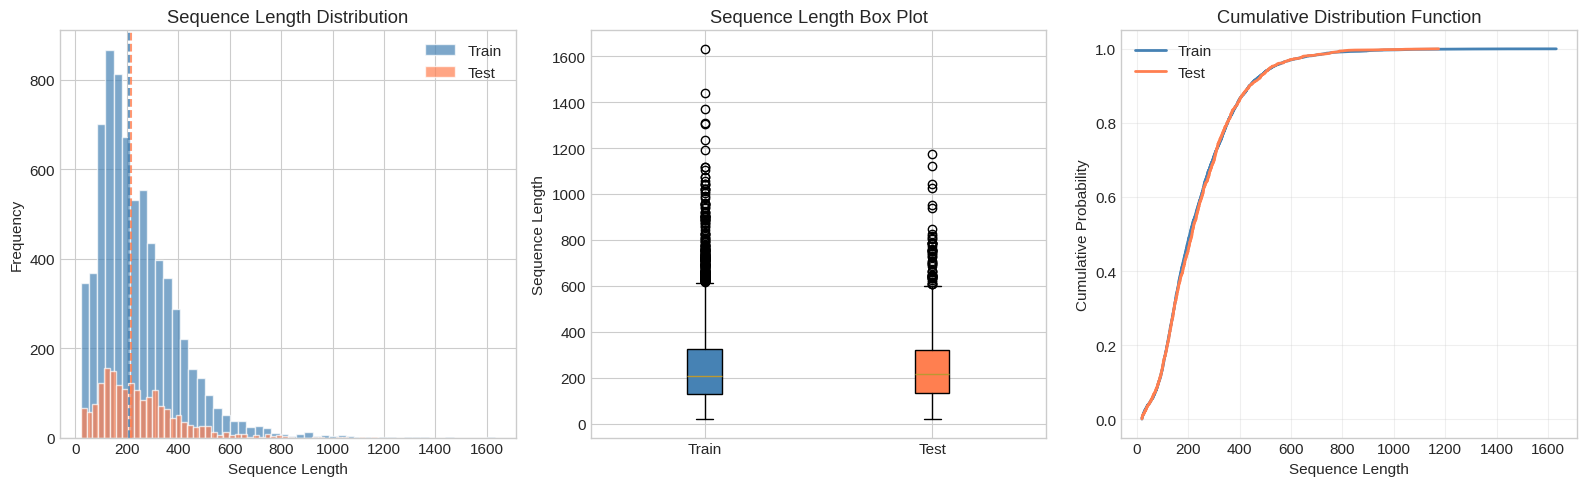

In [8]:
# Sequence length distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histogram comparison
axes[0].hist(train_df['seq_len'], bins=50, alpha=0.7, label='Train', color='steelblue', edgecolor='white')
axes[0].hist(test_df['seq_len'], bins=50, alpha=0.7, label='Test', color='coral', edgecolor='white')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sequence Length Distribution')
axes[0].legend()
axes[0].axvline(train_df['seq_len'].median(), color='steelblue', linestyle='--', alpha=0.8)
axes[0].axvline(test_df['seq_len'].median(), color='coral', linestyle='--', alpha=0.8)

# Box plot
box_data = [train_df['seq_len'].values, test_df['seq_len'].values]
bp = axes[1].boxplot(box_data, labels=['Train', 'Test'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
axes[1].set_ylabel('Sequence Length')
axes[1].set_title('Sequence Length Box Plot')

# CDF comparison
for df, label, color in [(train_df, 'Train', 'steelblue'), (test_df, 'Test', 'coral')]:
    sorted_len = np.sort(df['seq_len'])
    cdf = np.arange(1, len(sorted_len) + 1) / len(sorted_len)
    axes[2].plot(sorted_len, cdf, label=label, color=color, linewidth=2)
axes[2].set_xlabel('Sequence Length')
axes[2].set_ylabel('Cumulative Probability')
axes[2].set_title('Cumulative Distribution Function')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/seq_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Identify outliers (sequences with unusual lengths)
Q1, Q3 = train_df['seq_len'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df['seq_len'] < lower_bound) | (train_df['seq_len'] > upper_bound)]
print(f"\n📊 Outlier Analysis (IQR method):")
print(f"   Lower bound: {lower_bound:.0f}")
print(f"   Upper bound: {upper_bound:.0f}")
print(f"   Number of outliers: {len(outliers)} ({100*len(outliers)/len(train_df):.2f}%)")
print(f"   Shortest sequences: {sorted(train_df['seq_len'].nsmallest(5).values)}")
print(f"   Longest sequences: {sorted(train_df['seq_len'].nlargest(5).values)}")


📊 Outlier Analysis (IQR method):
   Lower bound: -158
   Upper bound: 614
   Number of outliers: 199 (2.74%)
   Shortest sequences: [np.int64(20), np.int64(20), np.int64(20), np.int64(20), np.int64(20)]
   Longest sequences: [np.int64(1305), np.int64(1310), np.int64(1372), np.int64(1440), np.int64(1632)]


### 3.2 Amino Acid Composition Analysis

In [10]:
# Standard amino acids
AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')

def get_aa_composition(sequences: pd.Series) -> Dict[str, float]:
    """Calculate amino acid composition from sequences."""
    all_residues = ''.join(sequences)
    total = len(all_residues)
    counter = Counter(all_residues)
    return {aa: counter.get(aa, 0) / total * 100 for aa in sorted(counter.keys())}

In [11]:
train_aa_comp = get_aa_composition(train_df['seq'])
test_aa_comp = get_aa_composition(test_df['seq'])

# Create comparison DataFrame
aa_comparison = pd.DataFrame({
    'Amino Acid': list(train_aa_comp.keys()),
    'Train (%)': list(train_aa_comp.values()),
    'Test (%)': [test_aa_comp.get(aa, 0) for aa in train_aa_comp.keys()]
})
aa_comparison['Difference'] = aa_comparison['Train (%)'] - aa_comparison['Test (%)']
aa_comparison = aa_comparison.sort_values('Train (%)', ascending=False)

print("=" * 60)
print("AMINO ACID COMPOSITION")
print("=" * 60)
print(aa_comparison.to_string(index=False))

AMINO ACID COMPOSITION
Amino Acid  Train (%)  Test (%)  Difference
         L   9.096269  9.168483   -0.072214
         A   8.247308  8.249335   -0.002027
         G   7.321870  7.314181    0.007689
         V   6.799681  6.758228    0.041453
         E   6.669516  6.601317    0.068199
         S   6.281290  6.255256    0.026035
         D   5.938815  5.922721    0.016093
         K   5.630127  5.663232   -0.033104
         I   5.522016  5.493244    0.028772
         T   5.432046  5.394499    0.037547
         R   5.070975  5.120355   -0.049380
         P   4.623903  4.565980    0.057923
         N   4.317880  4.274252    0.043629
         F   3.999839  4.041590   -0.041751
         Q   3.754420  3.812085   -0.057665
         Y   3.494204  3.570857   -0.076653
         H   2.893610  2.836801    0.056809
         M   2.286043  2.353893   -0.067850
         W   1.423760  1.416710    0.007050
         C   1.188715  1.182470    0.006245
         *   0.007710  0.004509    0.003201


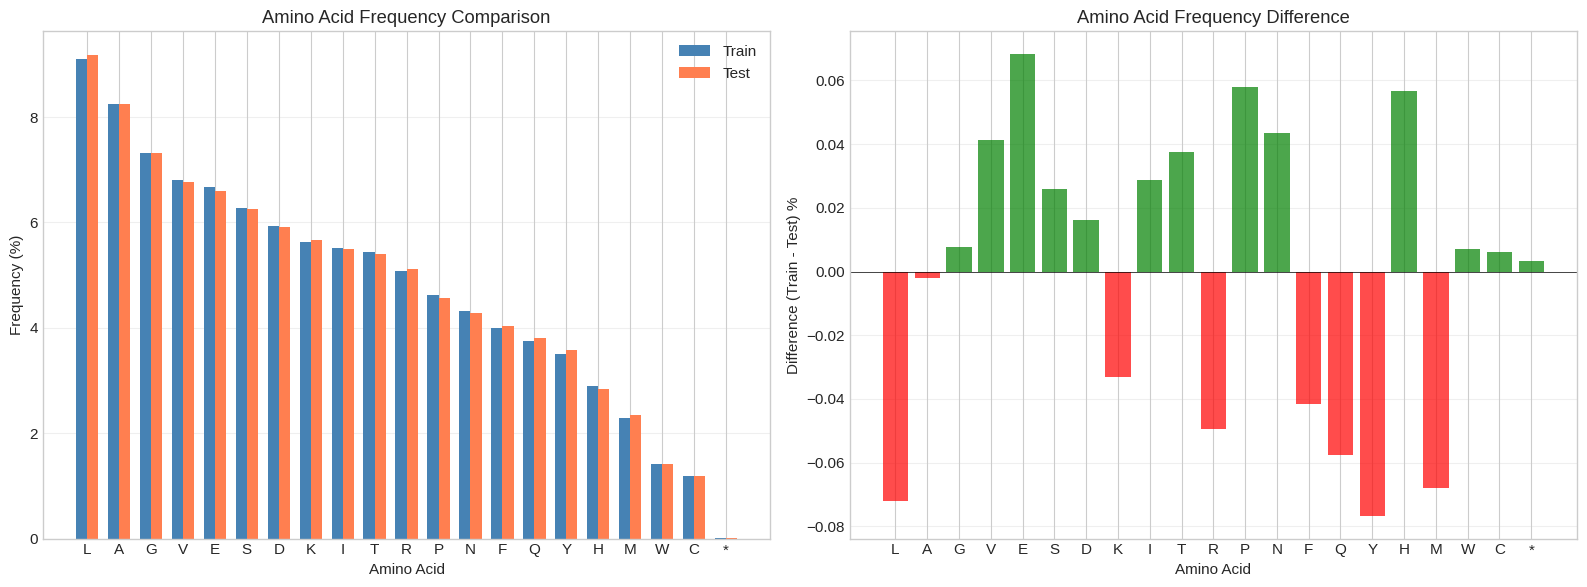

In [12]:
# Amino acid composition visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparison
x = np.arange(len(aa_comparison))
width = 0.35

bars1 = axes[0].bar(x - width/2, aa_comparison['Train (%)'], width, label='Train', color='steelblue')
bars2 = axes[0].bar(x + width/2, aa_comparison['Test (%)'], width, label='Test', color='coral')
axes[0].set_xlabel('Amino Acid')
axes[0].set_ylabel('Frequency (%)')
axes[0].set_title('Amino Acid Frequency Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(aa_comparison['Amino Acid'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Difference plot
colors = ['green' if d >= 0 else 'red' for d in aa_comparison['Difference']]
axes[1].bar(range(len(aa_comparison)), aa_comparison['Difference'], color=colors, alpha=0.7)
axes[1].set_xlabel('Amino Acid')
axes[1].set_ylabel('Difference (Train - Test) %')
axes[1].set_title('Amino Acid Frequency Difference')
axes[1].set_xticks(range(len(aa_comparison)))
axes[1].set_xticklabels(aa_comparison['Amino Acid'])
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/amino_acid_composition.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Check for non-standard amino acids
all_train_residues = set(''.join(train_df['seq']))
all_test_residues = set(''.join(test_df['seq']))
standard_aa_set = set(AMINO_ACIDS)

non_standard_train = all_train_residues - standard_aa_set
non_standard_test = all_test_residues - standard_aa_set

print(f"\n🧪 Non-standard Amino Acids:")
print(f"   In Train: {non_standard_train if non_standard_train else 'None'}")
print(f"   In Test:  {non_standard_test if non_standard_test else 'None'}")

if non_standard_train or non_standard_test:
    print("\n   ⚠️  Warning: Non-standard amino acids detected! May need special handling.")


🧪 Non-standard Amino Acids:
   In Train: {'*'}
   In Test:  {'*'}

   ⚠️  Warning: Non-standard amino acids detected! May need special handling.


## 4. SST8 Secondary Structure Analysis

### 4.1 SST8 Class Definitions

The DSSP (Dictionary of Secondary Structure of Proteins) 8-class scheme:
- **G**: 3₁₀-helix (rare)
- **H**: α-helix (common)
- **I**: π-helix (very rare)
- **E**: β-strand (common)
- **B**: β-bridge (rare)
- **T**: Turn
- **S**: Bend
- **C**: Coil (most common)

In [14]:
SST8_CLASSES = list('GHIEBSTC')
SST8_NAMES = {
    'G': '3₁₀-helix',
    'H': 'α-helix',
    'I': 'π-helix',
    'E': 'β-strand',
    'B': 'β-bridge',
    'T': 'Turn',
    'S': 'Bend',
    'C': 'Coil'
}

In [15]:
# Calculate SST8 class distribution
all_sst8 = ''.join(train_df['sst8'])
sst8_counter = Counter(all_sst8)
total_residues = len(all_sst8)

sst8_dist = pd.DataFrame({
    'Class': SST8_CLASSES,
    'Name': [SST8_NAMES[c] for c in SST8_CLASSES],
    'Count': [sst8_counter.get(c, 0) for c in SST8_CLASSES],
    'Percentage': [sst8_counter.get(c, 0) / total_residues * 100 for c in SST8_CLASSES]
})
sst8_dist = sst8_dist.sort_values('Count', ascending=False)
sst8_dist['Imbalance Ratio'] = sst8_dist['Count'].max() / sst8_dist['Count']

print("=" * 60)
print("SST8 CLASS DISTRIBUTION (Per-Residue)")
print("=" * 60)
print(f"\nTotal Residues: {total_residues:,}")
print(sst8_dist.to_string(index=False))

SST8 CLASS DISTRIBUTION (Per-Residue)

Total Residues: 1,763,921
Class      Name  Count  Percentage  Imbalance Ratio
    H   α-helix 556686   31.559577         1.000000
    C      Coil 427095   24.212819         1.303424
    E  β-strand 370480   21.003208         1.502607
    T      Turn 187629   10.637041         2.966951
    S      Bend 136515    7.739292         4.077838
    G 3₁₀-helix  66580    3.774545         8.361160
    B  β-bridge  18612    1.055149        29.910058
    I   π-helix    324    0.018368      1718.166667


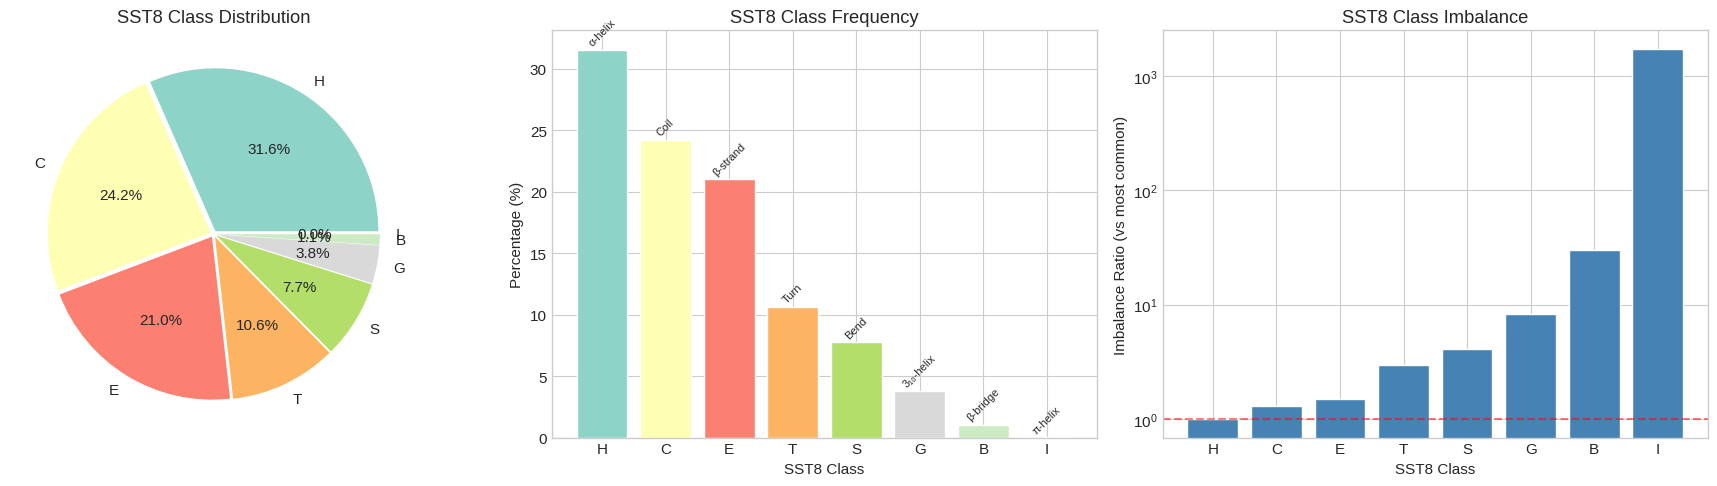

In [16]:
# SST8 visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, 8))
wedges, texts, autotexts = axes[0].pie(
    sst8_dist['Count'], 
    labels=sst8_dist['Class'],
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.02] * 8
)
axes[0].set_title('SST8 Class Distribution')

# Bar chart
bars = axes[1].bar(sst8_dist['Class'], sst8_dist['Percentage'], color=colors, edgecolor='white')
axes[1].set_xlabel('SST8 Class')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('SST8 Class Frequency')
for bar, name in zip(bars, sst8_dist['Name']):
    axes[1].annotate(name, xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8, rotation=45)

# Imbalance ratio (log scale)
axes[2].bar(sst8_dist['Class'], sst8_dist['Imbalance Ratio'], color='steelblue', edgecolor='white')
axes[2].set_xlabel('SST8 Class')
axes[2].set_ylabel('Imbalance Ratio (vs most common)')
axes[2].set_title('SST8 Class Imbalance')
axes[2].set_yscale('log')
axes[2].axhline(y=1, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/sst8_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Per-protein SST8 class proportions
def get_class_proportions(label_series: pd.Series, classes: List[str]) -> pd.DataFrame:
    """Calculate class proportions for each sample."""
    proportions = []
    for label in label_series:
        counter = Counter(label)
        total = len(label)
        props = {c: counter.get(c, 0) / total * 100 for c in classes}
        proportions.append(props)
    return pd.DataFrame(proportions)

sst8_proportions = get_class_proportions(train_df['sst8'], SST8_CLASSES)

print("\n📊 Per-Protein SST8 Proportion Statistics:")
print(sst8_proportions.describe().round(2))


📊 Per-Protein SST8 Proportion Statistics:
             G        H        I        E        B        S        T        C
count  7262.00  7262.00  7262.00  7262.00  7262.00  7262.00  7262.00  7262.00
mean      3.52    32.16     0.01    21.00     0.97     7.16    10.16    25.02
std       2.86    20.43     0.18    14.95     1.21     3.41     3.91    10.33
min       0.00     0.00     0.00     0.00     0.00     0.00     0.00     1.98
25%       1.50    18.44     0.00    11.00     0.00     5.03     7.92    19.20
50%       3.28    31.29     0.00    19.63     0.71     7.12    10.20    23.39
75%       5.15    42.86     0.00    30.70     1.51     9.20    12.40    28.24
max      30.43    97.85     8.33    75.00    21.88    30.77    40.00    99.07


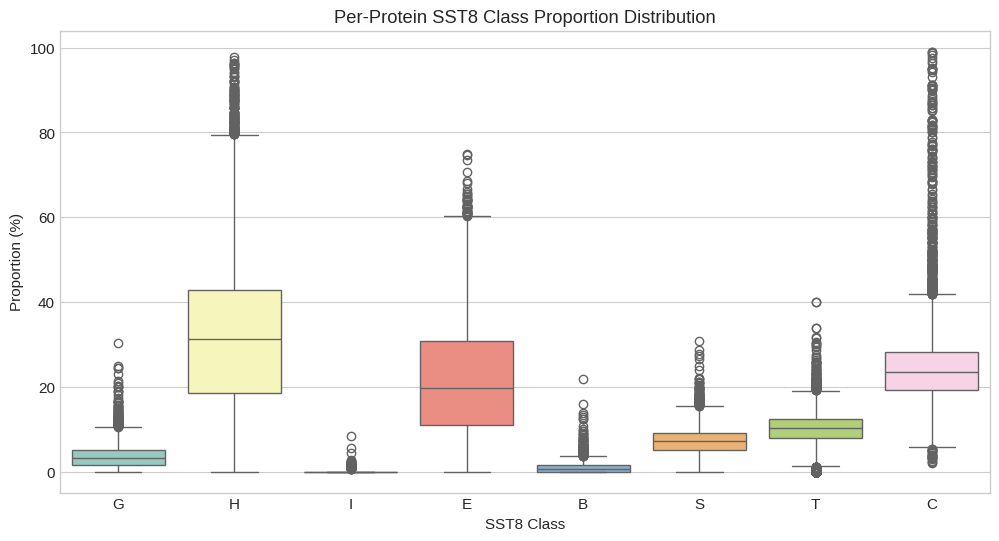

In [18]:
# Box plot for per-protein proportions
fig, ax = plt.subplots(figsize=(12, 6))
sst8_proportions_melted = sst8_proportions.melt(var_name='SST8 Class', value_name='Proportion (%)')
sns.boxplot(data=sst8_proportions_melted, x='SST8 Class', y='Proportion (%)', palette='Set3', ax=ax)
ax.set_title('Per-Protein SST8 Class Proportion Distribution')
plt.savefig(f'{DATA_DIR}/../notebooks/eda/sst8_per_protein_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. SST3 Secondary Structure Analysis

### 5.1 SST3 Class Definitions

The 3-class scheme (reduced from SST8):
- **H**: Helix (includes G, H, I from SST8)
- **E**: Strand (includes E, B from SST8)
- **C**: Coil (includes T, S, C from SST8)

In [19]:
SST3_CLASSES = list('HEC')
SST3_NAMES = {'H': 'Helix', 'E': 'Strand', 'C': 'Coil'}

# Mapping from SST8 to SST3
SST8_TO_SST3 = {
    'G': 'H', 'H': 'H', 'I': 'H',  # Helix
    'E': 'E', 'B': 'E',             # Strand
    'T': 'C', 'S': 'C', 'C': 'C'    # Coil
}

In [20]:
# Calculate SST3 class distribution
all_sst3 = ''.join(train_df['sst3'])
sst3_counter = Counter(all_sst3)
total_residues_sst3 = len(all_sst3)

sst3_dist = pd.DataFrame({
    'Class': SST3_CLASSES,
    'Name': [SST3_NAMES[c] for c in SST3_CLASSES],
    'Count': [sst3_counter.get(c, 0) for c in SST3_CLASSES],
    'Percentage': [sst3_counter.get(c, 0) / total_residues_sst3 * 100 for c in SST3_CLASSES]
})
sst3_dist = sst3_dist.sort_values('Count', ascending=False)
sst3_dist['Imbalance Ratio'] = sst3_dist['Count'].max() / sst3_dist['Count']

print("=" * 60)
print("SST3 CLASS DISTRIBUTION (Per-Residue)")
print("=" * 60)
print(f"\nTotal Residues: {total_residues_sst3:,}")
print(sst3_dist.to_string(index=False))

SST3 CLASS DISTRIBUTION (Per-Residue)

Total Residues: 1,763,921
Class   Name  Count  Percentage  Imbalance Ratio
    C   Coil 751239   42.589152         1.000000
    H  Helix 623590   35.352490         1.204700
    E Strand 389092   22.058357         1.930749


In [21]:
# Verify SST8 → SST3 mapping consistency
def verify_sst_mapping(sst8: str, sst3: str) -> bool:
    """Check if SST3 labels are consistent with SST8 → SST3 mapping."""
    expected_sst3 = ''.join([SST8_TO_SST3[c] for c in sst8])
    return expected_sst3 == sst3

mapping_check = train_df.apply(lambda row: verify_sst_mapping(row['sst8'], row['sst3']), axis=1)
inconsistent_mappings = train_df[~mapping_check]

print(f"\n🔍 SST8 → SST3 Mapping Verification:")
print(f"   Consistent: {mapping_check.sum():,} ({100*mapping_check.sum()/len(train_df):.2f}%)")
print(f"   Inconsistent: {len(inconsistent_mappings):,}")

if len(inconsistent_mappings) > 0:
    print("\n   ⚠️  Warning: Some SST8/SST3 labels are inconsistent!")
    print(inconsistent_mappings[['id', 'sst8', 'sst3']].head())


🔍 SST8 → SST3 Mapping Verification:
   Consistent: 7,262 (100.00%)
   Inconsistent: 0


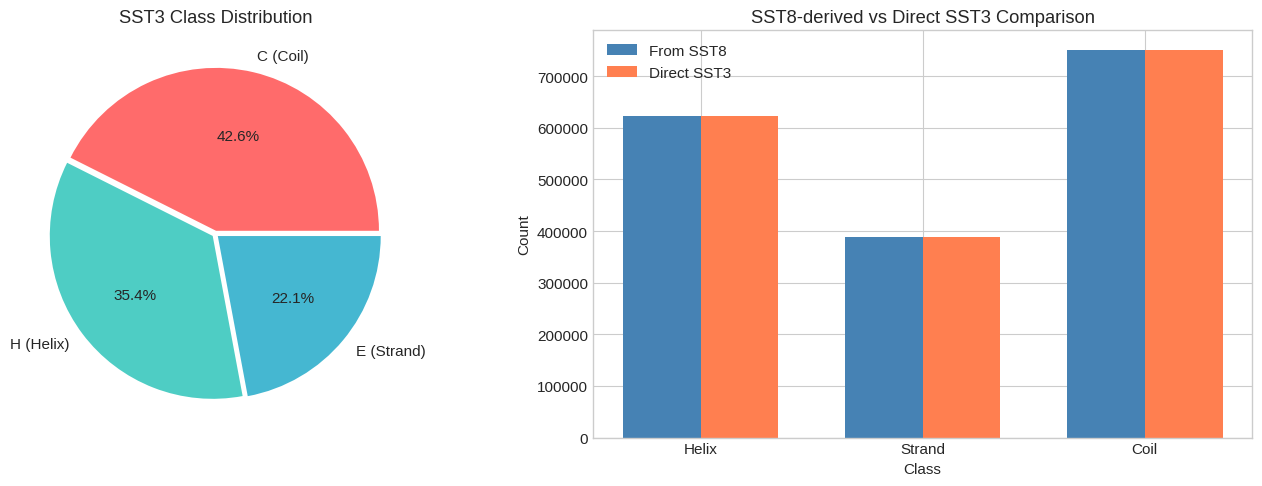

In [22]:
# SST3 visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors_sst3 = ['#FF6B6B', '#4ECDC4', '#45B7D1']
wedges, texts, autotexts = axes[0].pie(
    sst3_dist['Count'], 
    labels=[f"{c} ({SST3_NAMES[c]})" for c in sst3_dist['Class']],
    autopct='%1.1f%%',
    colors=colors_sst3,
    explode=[0.02] * 3
)
axes[0].set_title('SST3 Class Distribution')

# Compare SST8 vs SST3 class balance
sst8_groups = {
    'H (Helix)': sst8_dist[sst8_dist['Class'].isin(['G', 'H', 'I'])]['Count'].sum(),
    'E (Strand)': sst8_dist[sst8_dist['Class'].isin(['E', 'B'])]['Count'].sum(),
    'C (Coil)': sst8_dist[sst8_dist['Class'].isin(['T', 'S', 'C'])]['Count'].sum()
}

x = np.arange(3)
width = 0.35
bars1 = axes[1].bar(x - width/2, list(sst8_groups.values()), width, label='From SST8', color='steelblue')
bars2 = axes[1].bar(x + width/2, sst3_dist.set_index('Class').loc[['H', 'E', 'C'], 'Count'].values, 
                     width, label='Direct SST3', color='coral')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('SST8-derived vs Direct SST3 Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Helix', 'Strand', 'Coil'])
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/sst3_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Per-protein SST3 proportions
sst3_proportions = get_class_proportions(train_df['sst3'], SST3_CLASSES)

print("\n📊 Per-Protein SST3 Proportion Statistics:")
print(sst3_proportions.describe().round(2))


📊 Per-Protein SST3 Proportion Statistics:
             H        E        C
count  7262.00  7262.00  7262.00
mean     35.70    21.97    42.34
std      20.22    15.09    11.38
min       0.00     0.00     2.15
25%      22.40    12.06    36.23
50%      35.43    20.69    41.88
75%      46.67    31.78    47.67
max      97.85    75.68   100.00


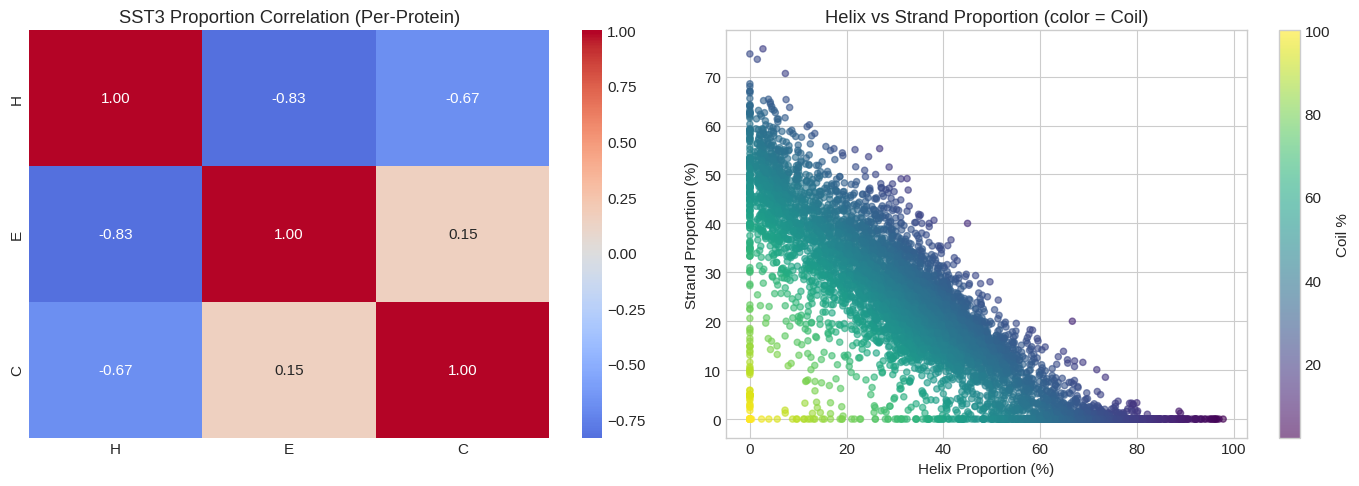

In [24]:
# Heatmap of SST3 proportions correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
corr_matrix = sst3_proportions.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0], fmt='.2f')
axes[0].set_title('SST3 Proportion Correlation (Per-Protein)')

# 2D scatter of H vs E proportions
scatter = axes[1].scatter(sst3_proportions['H'], sst3_proportions['E'], 
                          c=sst3_proportions['C'], cmap='viridis', alpha=0.6, s=20)
axes[1].set_xlabel('Helix Proportion (%)')
axes[1].set_ylabel('Strand Proportion (%)')
axes[1].set_title('Helix vs Strand Proportion (color = Coil)')
plt.colorbar(scatter, ax=axes[1], label='Coil %')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/sst3_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Sequence-Structure Relationships

### 6.1 Sequence Length vs Structure Composition

In [25]:
# Add proportions to train_df for analysis
train_df['helix_pct'] = sst3_proportions['H']
train_df['strand_pct'] = sst3_proportions['E']
train_df['coil_pct'] = sst3_proportions['C']

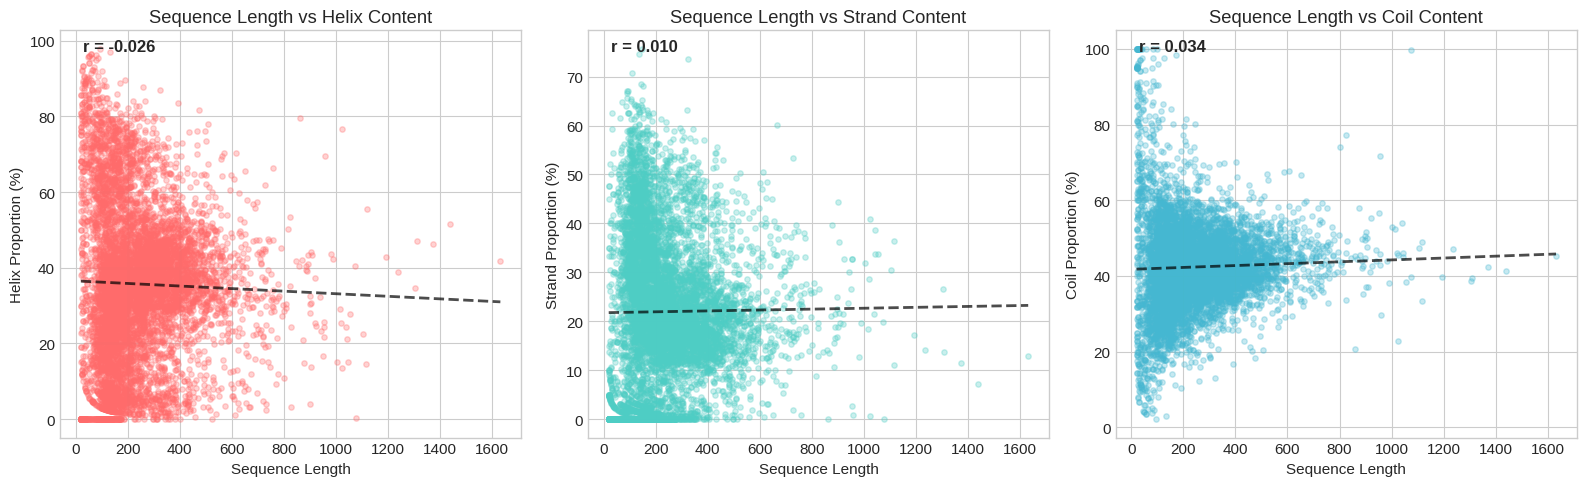

In [26]:
# Correlation between sequence length and structure composition
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (col, name, color) in enumerate([
    ('helix_pct', 'Helix', '#FF6B6B'),
    ('strand_pct', 'Strand', '#4ECDC4'),
    ('coil_pct', 'Coil', '#45B7D1')
]):
    axes[i].scatter(train_df['seq_len'], train_df[col], alpha=0.3, s=15, color=color)
    axes[i].set_xlabel('Sequence Length')
    axes[i].set_ylabel(f'{name} Proportion (%)')
    axes[i].set_title(f'Sequence Length vs {name} Content')
    
    # Add trend line
    z = np.polyfit(train_df['seq_len'], train_df[col], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train_df['seq_len'].min(), train_df['seq_len'].max(), 100)
    axes[i].plot(x_line, p(x_line), 'k--', alpha=0.7, linewidth=2)
    
    # Calculate correlation
    corr = train_df['seq_len'].corr(train_df[col])
    axes[i].annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                     fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/length_vs_structure.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Amino Acid Preferences for Secondary Structures

In [27]:
# Calculate amino acid preferences for each SST3 class
def get_aa_preferences(df: pd.DataFrame, structure_col: str) -> pd.DataFrame:
    """Calculate amino acid frequency for each secondary structure class."""
    aa_struct_counts = {aa: {c: 0 for c in SST3_CLASSES} for aa in AMINO_ACIDS}
    
    for _, row in df.iterrows():
        seq = row['seq']
        struct = row[structure_col]
        for aa, ss in zip(seq, struct):
            if aa in aa_struct_counts and ss in SST3_CLASSES:
                aa_struct_counts[aa][ss] += 1
    
    # Convert to DataFrame and normalize
    result = pd.DataFrame(aa_struct_counts).T
    result = result.div(result.sum(axis=0), axis=1) * 100  # Normalize by structure class
    return result

aa_pref = get_aa_preferences(train_df, 'sst3')

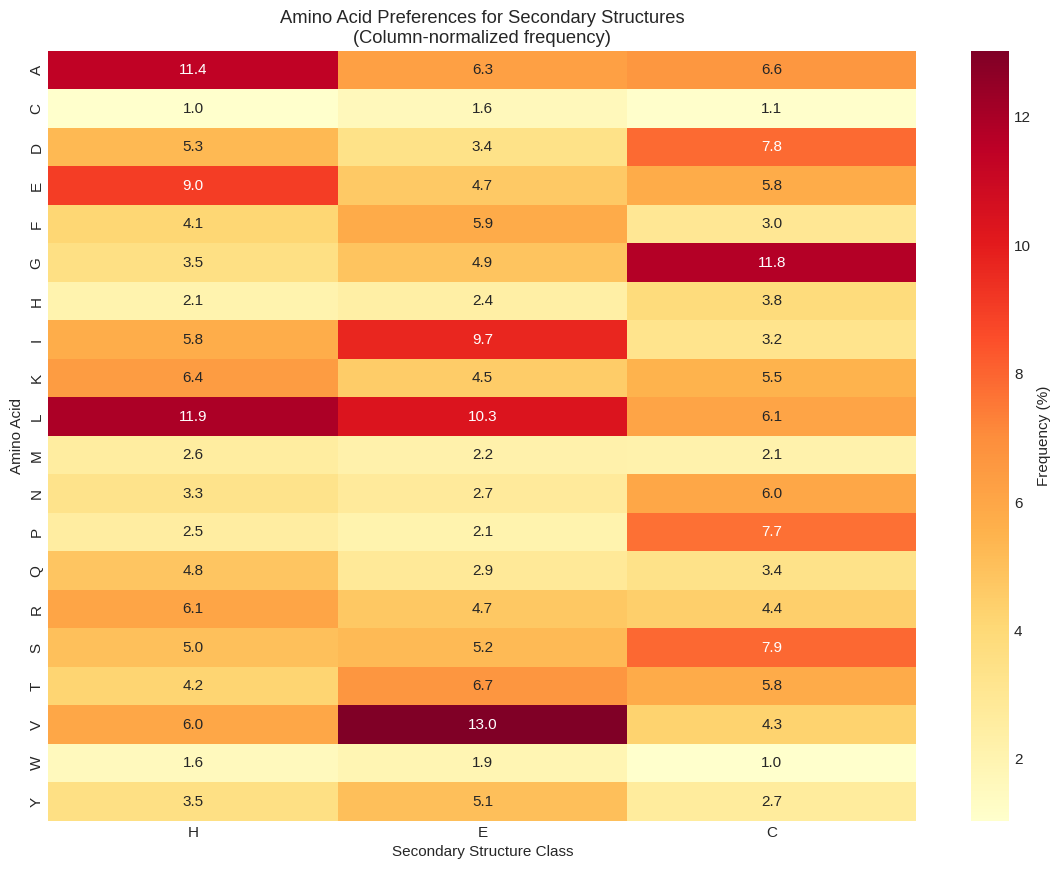

In [28]:
# Heatmap of amino acid preferences
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(aa_pref, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, 
            cbar_kws={'label': 'Frequency (%)'})
ax.set_xlabel('Secondary Structure Class')
ax.set_ylabel('Amino Acid')
ax.set_title('Amino Acid Preferences for Secondary Structures\n(Column-normalized frequency)')
plt.savefig(f'{DATA_DIR}/../notebooks/eda/aa_structure_preferences.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
# Find top discriminative amino acids
aa_pref_std = aa_pref.std(axis=1).sort_values(ascending=False)
print("\n🔬 Most Discriminative Amino Acids (by std across structure classes):")
print(aa_pref_std.head(10))


🔬 Most Discriminative Amino Acids (by std across structure classes):
V    4.642112
G    4.420468
I    3.254168
P    3.141985
L    2.994940
A    2.882382
E    2.248163
D    2.226455
N    1.721993
S    1.594874
dtype: float64


### 6.3 Positional Structure Distribution

In [30]:
# Analyze N-terminal and C-terminal structure preferences
def get_positional_structure(df: pd.DataFrame, position: str, n_residues: int = 20) -> Dict[str, float]:
    """Calculate structure distribution at N-terminal or C-terminal."""
    all_struct = []
    for struct in df['sst3']:
        if position == 'N':
            all_struct.extend(list(struct[:n_residues]))
        else:
            all_struct.extend(list(struct[-n_residues:]))
    
    counter = Counter(all_struct)
    total = sum(counter.values())
    return {c: counter.get(c, 0) / total * 100 for c in SST3_CLASSES}

n_terminal = get_positional_structure(train_df, 'N', 20)
c_terminal = get_positional_structure(train_df, 'C', 20)
overall = {c: sst3_counter.get(c, 0) / total_residues_sst3 * 100 for c in SST3_CLASSES}

print("=" * 60)
print("POSITIONAL STRUCTURE DISTRIBUTION")
print("=" * 60)
print("\n{:<15} {:>12} {:>12} {:>12}".format("Class", "N-terminal", "C-terminal", "Overall"))
print("-" * 55)
for c in SST3_CLASSES:
    print("{:<15} {:>12.2f} {:>12.2f} {:>12.2f}".format(
        f"{c} ({SST3_NAMES[c]})", n_terminal[c], c_terminal[c], overall[c]))

POSITIONAL STRUCTURE DISTRIBUTION

Class             N-terminal   C-terminal      Overall
-------------------------------------------------------
H (Helix)              33.83        24.26        35.35
E (Strand)             16.90        16.25        22.06
C (Coil)               49.27        59.49        42.59


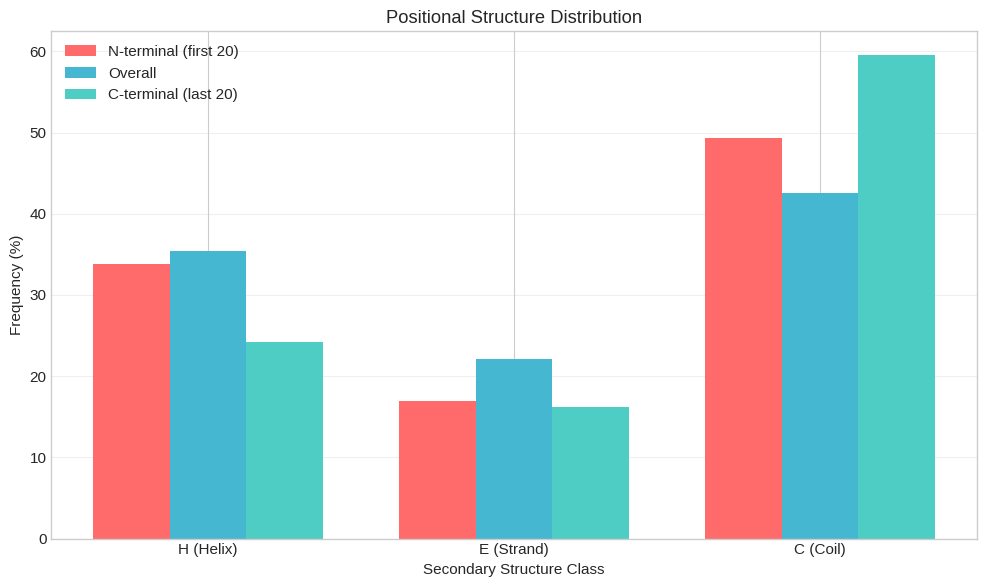

In [31]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(3)
width = 0.25

bars1 = ax.bar(x - width, [n_terminal[c] for c in SST3_CLASSES], width, label='N-terminal (first 20)', color='#FF6B6B')
bars2 = ax.bar(x, [overall[c] for c in SST3_CLASSES], width, label='Overall', color='#45B7D1')
bars3 = ax.bar(x + width, [c_terminal[c] for c in SST3_CLASSES], width, label='C-terminal (last 20)', color='#4ECDC4')

ax.set_xlabel('Secondary Structure Class')
ax.set_ylabel('Frequency (%)')
ax.set_title('Positional Structure Distribution')
ax.set_xticks(x)
ax.set_xticklabels([f'{c} ({SST3_NAMES[c]})' for c in SST3_CLASSES])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/positional_structure.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Data Leakage Analysis

**Critical Section**: This analysis identifies potential data leakage between train and test sets,
which is essential for ensuring model validation integrity.

### 7.1 Exact Sequence Match Detection

In [32]:
# Hash-based exact match detection
def get_sequence_hash(seq: str) -> str:
    """Generate MD5 hash for a sequence."""
    return hashlib.md5(seq.encode()).hexdigest()

train_df['seq_hash'] = train_df['seq'].apply(get_sequence_hash)
test_df['seq_hash'] = test_df['seq'].apply(get_sequence_hash)

# Find exact matches
train_hashes = set(train_df['seq_hash'])
test_hashes = set(test_df['seq_hash'])
exact_matches = train_hashes.intersection(test_hashes)

print("=" * 60)
print("EXACT SEQUENCE MATCH ANALYSIS")
print("=" * 60)
print(f"\n🔍 Unique sequences in train: {len(train_hashes):,}")
print(f"🔍 Unique sequences in test:  {len(test_hashes):,}")
print(f"⚠️  EXACT MATCHES: {len(exact_matches)}")

if len(exact_matches) > 0:
    print("\n📋 Matching sequences:")
    for hash_val in list(exact_matches)[:10]:  # Show first 10
        train_match = train_df[train_df['seq_hash'] == hash_val].iloc[0]
        test_match = test_df[test_df['seq_hash'] == hash_val].iloc[0]
        print(f"\n   Train ID: {train_match['id']}, Test ID: {test_match['id']}")
        print(f"   Length: {len(train_match['seq'])}")
        print(f"   Sequence: {train_match['seq'][:50]}...")

EXACT SEQUENCE MATCH ANALYSIS

🔍 Unique sequences in train: 7,262
🔍 Unique sequences in test:  1,816
⚠️  EXACT MATCHES: 0


In [33]:
# Create leakage dataframe for isolation
if len(exact_matches) > 0:
    exact_leak_train = train_df[train_df['seq_hash'].isin(exact_matches)][['id', 'seq', 'seq_hash']].copy()
    exact_leak_test = test_df[test_df['seq_hash'].isin(exact_matches)][['id', 'seq', 'seq_hash']].copy()
    exact_leak_train['source'] = 'train'
    exact_leak_test['source'] = 'test'
    exact_leakage_df = pd.concat([exact_leak_train, exact_leak_test])
    print(f"\n📊 Exact leakage summary:")
    print(f"   Train samples to isolate: {len(exact_leak_train)}")
    print(f"   Test samples affected: {len(exact_leak_test)}")

### 7.2 Duplicate Detection Within Datasets

In [34]:
# Check for duplicates within train and test separately
train_duplicates = train_df[train_df.duplicated(subset='seq_hash', keep=False)]
test_duplicates = test_df[test_df.duplicated(subset='seq_hash', keep=False)]

print("=" * 60)
print("INTRA-DATASET DUPLICATE ANALYSIS")
print("=" * 60)
print(f"\n🔍 Duplicate sequences in TRAIN: {len(train_duplicates)} ({len(train_duplicates.drop_duplicates('seq_hash'))} unique)")
print(f"🔍 Duplicate sequences in TEST:  {len(test_duplicates)} ({len(test_duplicates.drop_duplicates('seq_hash'))} unique)")

if len(train_duplicates) > 0:
    print("\n   ⚠️  Warning: Training data contains duplicate sequences!")
    dup_groups = train_duplicates.groupby('seq_hash').agg({'id': list, 'seq': 'first'})
    print(f"   Number of duplicate groups: {len(dup_groups)}")

INTRA-DATASET DUPLICATE ANALYSIS

🔍 Duplicate sequences in TRAIN: 0 (0 unique)
🔍 Duplicate sequences in TEST:  0 (0 unique)


### 7.3 Subsequence Overlap Analysis

In [35]:
# K-mer based overlap analysis
def extract_kmers(sequence: str, k: int) -> set:
    """Extract all k-mers from a sequence."""
    return set(sequence[i:i+k] for i in range(len(sequence) - k + 1))

def calculate_kmer_overlap(seq1: str, seq2: str, k: int) -> float:
    """Calculate Jaccard similarity based on shared k-mers."""
    kmers1 = extract_kmers(seq1, k)
    kmers2 = extract_kmers(seq2, k)
    if len(kmers1) == 0 or len(kmers2) == 0:
        return 0.0
    intersection = len(kmers1.intersection(kmers2))
    union = len(kmers1.union(kmers2))
    return intersection / union if union > 0 else 0.0

In [36]:
# Aggregate k-mer analysis
K_VALUES = [5, 7, 10]

print("=" * 60)
print("K-MER OVERLAP ANALYSIS")
print("=" * 60)

for k in K_VALUES:
    # Extract all k-mers from train and test
    train_kmers = set()
    for seq in train_df['seq']:
        train_kmers.update(extract_kmers(seq, k))
    
    test_kmers = set()
    for seq in test_df['seq']:
        test_kmers.update(extract_kmers(seq, k))
    
    shared_kmers = train_kmers.intersection(test_kmers)
    
    print(f"\nk = {k}:")
    print(f"   Unique {k}-mers in train: {len(train_kmers):,}")
    print(f"   Unique {k}-mers in test:  {len(test_kmers):,}")
    print(f"   Shared {k}-mers: {len(shared_kmers):,} ({100*len(shared_kmers)/len(test_kmers):.1f}% of test)")

K-MER OVERLAP ANALYSIS



k = 5:
   Unique 5-mers in train: 1,047,857
   Unique 5-mers in test:  368,928
   Shared 5-mers: 213,717 (57.9% of test)



k = 7:
   Unique 7-mers in train: 1,695,488
   Unique 7-mers in test:  429,337
   Shared 7-mers: 4,858 (1.1% of test)



k = 10:
   Unique 10-mers in train: 1,685,287
   Unique 10-mers in test:  425,597
   Shared 10-mers: 1,864 (0.4% of test)


### 7.4 High-Similarity Sequence Detection

In [37]:
# Pairwise similarity analysis (sampling-based for efficiency)
from difflib import SequenceMatcher

def sequence_similarity(seq1: str, seq2: str) -> float:
    """Calculate sequence similarity using SequenceMatcher."""
    return SequenceMatcher(None, seq1, seq2).ratio()

In [38]:
# Sample-based high-similarity detection
SIMILARITY_THRESHOLD = 0.9  # 90% similarity threshold
SAMPLE_SIZE = min(500, len(test_df))  # Sample from test for efficiency

np.random.seed(42)
test_sample_idx = np.random.choice(len(test_df), SAMPLE_SIZE, replace=False)
test_sample = test_df.iloc[test_sample_idx]

print("=" * 60)
print("HIGH-SIMILARITY SEQUENCE DETECTION")
print("=" * 60)
print(f"\n🔍 Analyzing {SAMPLE_SIZE} test sequences against all train sequences...")
print(f"   Similarity threshold: {SIMILARITY_THRESHOLD*100}%")

high_similarity_pairs = []

for test_idx, test_row in test_sample.iterrows():
    test_seq = test_row['seq']
    test_len = len(test_seq)
    
    # Pre-filter by length (similar length proteins more likely to be similar)
    length_filtered = train_df[
        (train_df['seq_len'] >= test_len * 0.8) & 
        (train_df['seq_len'] <= test_len * 1.2)
    ]
    
    for train_idx, train_row in length_filtered.iterrows():
        if train_row['seq_hash'] == test_row['seq_hash']:
            continue  # Skip exact matches (already handled)
        
        sim = sequence_similarity(test_seq, train_row['seq'])
        if sim >= SIMILARITY_THRESHOLD:
            high_similarity_pairs.append({
                'test_id': test_row['id'],
                'train_id': train_row['id'],
                'similarity': sim,
                'test_len': test_len,
                'train_len': len(train_row['seq'])
            })

print(f"\n⚠️  High-similarity pairs found: {len(high_similarity_pairs)}")

if len(high_similarity_pairs) > 0:
    sim_df = pd.DataFrame(high_similarity_pairs)
    sim_df = sim_df.sort_values('similarity', ascending=False)
    print("\n   Top 10 similar pairs:")
    print(sim_df.head(10).to_string(index=False))
    
    # Save for later isolation
    sim_df.to_csv(f'{DATA_DIR}/../notebooks/eda/high_similarity_pairs.csv', index=False)
    print(f"\n   Saved to: notebooks/eda/high_similarity_pairs.csv")

HIGH-SIMILARITY SEQUENCE DETECTION

🔍 Analyzing 500 test sequences against all train sequences...
   Similarity threshold: 90.0%



⚠️  High-similarity pairs found: 1

   Top 10 similar pairs:
 test_id  train_id  similarity  test_len  train_len
     371      6552    0.987342        39         40

   Saved to: notebooks/eda/high_similarity_pairs.csv


### 7.5 Levenshtein Distance Analysis

In [39]:
# Efficient edit distance for sampling
def levenshtein_distance(s1: str, s2: str) -> int:
    """Calculate Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [40]:
# Sample analysis for edit distance distribution
SAMPLE_PAIRS = 1000
np.random.seed(42)

edit_distances = []
for _ in range(SAMPLE_PAIRS):
    train_seq = train_df['seq'].sample(1).iloc[0]
    test_seq = test_df['seq'].sample(1).iloc[0]
    
    # Truncate for efficiency if too long
    max_len = 200
    ed = levenshtein_distance(train_seq[:max_len], test_seq[:max_len])
    normalized_ed = ed / max(len(train_seq[:max_len]), len(test_seq[:max_len]))
    edit_distances.append(normalized_ed)

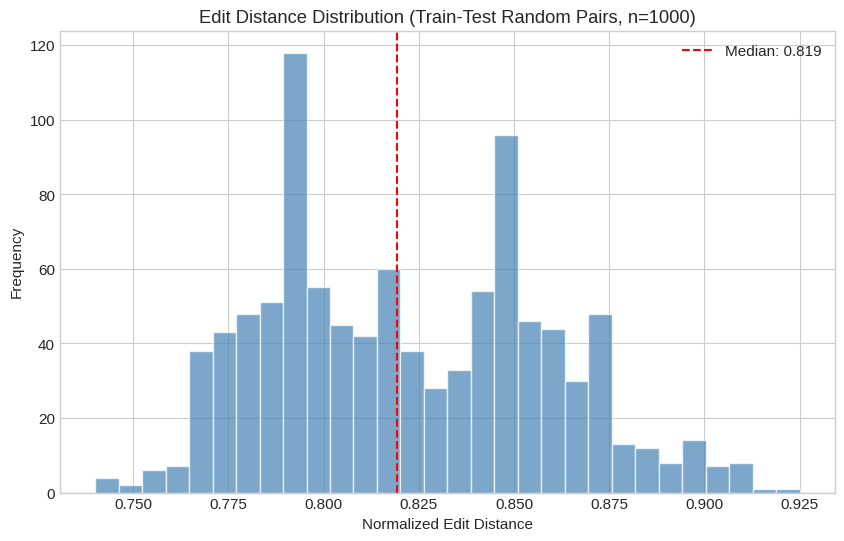


📊 Edit Distance Statistics:
   Mean: 0.822
   Std:  0.036
   Min:  0.740
   Max:  0.925


In [41]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(edit_distances, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax.axvline(x=np.median(edit_distances), color='red', linestyle='--', label=f'Median: {np.median(edit_distances):.3f}')
ax.set_xlabel('Normalized Edit Distance')
ax.set_ylabel('Frequency')
ax.set_title(f'Edit Distance Distribution (Train-Test Random Pairs, n={SAMPLE_PAIRS})')
ax.legend()
plt.savefig(f'{DATA_DIR}/../notebooks/eda/edit_distance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Edit Distance Statistics:")
print(f"   Mean: {np.mean(edit_distances):.3f}")
print(f"   Std:  {np.std(edit_distances):.3f}")
print(f"   Min:  {np.min(edit_distances):.3f}")
print(f"   Max:  {np.max(edit_distances):.3f}")

### 7.6 Data Leakage Summary

In [42]:
print("=" * 70)
print("DATA LEAKAGE SUMMARY")
print("=" * 70)

leakage_report = {
    'Exact Sequence Matches': len(exact_matches),
    'Train Duplicates': len(train_duplicates),
    'Test Duplicates': len(test_duplicates),
    'High Similarity Pairs (≥90%)': len(high_similarity_pairs),
    'Shared 10-mers (% of test)': f"{100*len(shared_kmers)/len(test_kmers):.1f}%"
}

for key, value in leakage_report.items():
    print(f"   {key}: {value}")

# Save leakage report
leakage_ids = {
    'exact_match_train_ids': list(train_df[train_df['seq_hash'].isin(exact_matches)]['id']),
    'exact_match_test_ids': list(test_df[test_df['seq_hash'].isin(exact_matches)]['id']),
    'duplicate_train_ids': list(train_duplicates['id']),
    'duplicate_test_ids': list(test_duplicates['id']),
    'high_similarity_pairs': high_similarity_pairs
}

import json
with open(f'{DATA_DIR}/../notebooks/eda/leakage_report.json', 'w') as f:
    json.dump(leakage_ids, f, indent=2)

print(f"\n📁 Leakage report saved to: notebooks/eda/leakage_report.json")

DATA LEAKAGE SUMMARY
   Exact Sequence Matches: 0
   Train Duplicates: 0
   Test Duplicates: 0
   High Similarity Pairs (≥90%): 1
   Shared 10-mers (% of test): 0.4%

📁 Leakage report saved to: notebooks/eda/leakage_report.json


## 8. Summary & Recommendations

In [43]:
print("=" * 70)
print("COMPREHENSIVE EDA SUMMARY")
print("=" * 70)

print("""
📊 DATASET OVERVIEW:
   • Training set: {train_n:,} proteins ({train_res:,} residues)
   • Test set: {test_n:,} proteins (labels to be predicted)
   • Average sequence length: Train={train_avg:.0f}, Test={test_avg:.0f}
   • Length range: {min_len} - {max_len} residues

🧬 AMINO ACID COMPOSITION:
   • All 20 standard amino acids present
   • Non-standard amino acids: {non_std}
   • Train/Test composition is highly consistent (good for generalization)

🏗️ SECONDARY STRUCTURE DISTRIBUTION:
   SST8 (8-class):
   • Most common: {sst8_top1} ({sst8_top1_pct:.1f}%), {sst8_top2} ({sst8_top2_pct:.1f}%)
   • Rare classes: {sst8_rare} (< 1% each) - CLASS IMBALANCE ISSUE
   
   SST3 (3-class):
   • Coil: {coil_pct:.1f}%, Helix: {helix_pct:.1f}%, Strand: {strand_pct:.1f}%
   • More balanced than SST8 but Strand is underrepresented

⚠️ DATA LEAKAGE FINDINGS:
   • Exact sequence matches (train↔test): {exact_n}
   • High-similarity pairs (≥90%): {sim_n}
   • Action: Isolate {isolate_n} samples before training

📈 RECOMMENDATIONS FOR MODEL DESIGN:
   1. CLASS WEIGHTING: Use inverse frequency weights for rare SST8 classes
   2. SEQUENCE LENGTH: Consider padding/truncation strategy (median ~{median_len})
   3. DATA LEAKAGE: Remove/isolate identified overlapping sequences
   4. EVALUATION: Use both Q8 and Q3 accuracy metrics
   5. AUGMENTATION: Consider reverse complement or masking strategies
""".format(
    train_n=len(train_df),
    train_res=total_residues,
    test_n=len(test_df),
    train_avg=train_df['seq_len'].mean(),
    test_avg=test_df['seq_len'].mean(),
    min_len=train_df['seq_len'].min(),
    max_len=train_df['seq_len'].max(),
    non_std='None' if not non_standard_train else str(non_standard_train),
    sst8_top1=sst8_dist.iloc[0]['Class'],
    sst8_top1_pct=sst8_dist.iloc[0]['Percentage'],
    sst8_top2=sst8_dist.iloc[1]['Class'],
    sst8_top2_pct=sst8_dist.iloc[1]['Percentage'],
    sst8_rare=', '.join(sst8_dist[sst8_dist['Percentage'] < 1]['Class'].tolist()),
    coil_pct=sst3_dist[sst3_dist['Class']=='C']['Percentage'].values[0],
    helix_pct=sst3_dist[sst3_dist['Class']=='H']['Percentage'].values[0],
    strand_pct=sst3_dist[sst3_dist['Class']=='E']['Percentage'].values[0],
    exact_n=len(exact_matches),
    sim_n=len(high_similarity_pairs),
    isolate_n=len(exact_matches) + len(high_similarity_pairs),
    median_len=int(train_df['seq_len'].median())
))

COMPREHENSIVE EDA SUMMARY

📊 DATASET OVERVIEW:
   • Training set: 7,262 proteins (1,763,921 residues)
   • Test set: 1,816 proteins (labels to be predicted)
   • Average sequence length: Train=243, Test=244
   • Length range: 20 - 1632 residues

🧬 AMINO ACID COMPOSITION:
   • All 20 standard amino acids present
   • Non-standard amino acids: {'*'}
   • Train/Test composition is highly consistent (good for generalization)

🏗️ SECONDARY STRUCTURE DISTRIBUTION:
   SST8 (8-class):
   • Most common: H (31.6%), C (24.2%)
   • Rare classes: I (< 1% each) - CLASS IMBALANCE ISSUE

   SST3 (3-class):
   • Coil: 42.6%, Helix: 35.4%, Strand: 22.1%
   • More balanced than SST8 but Strand is underrepresented

⚠️ DATA LEAKAGE FINDINGS:
   • Exact sequence matches (train↔test): 0
   • High-similarity pairs (≥90%): 1
   • Action: Isolate 1 samples before training

📈 RECOMMENDATIONS FOR MODEL DESIGN:
   1. CLASS WEIGHTING: Use inverse frequency weights for rare SST8 classes
   2. SEQUENCE LENGTH: Consid

In [44]:
# Clean up temporary columns
train_df_clean = train_df.drop(columns=['seq_len', 'sst8_len', 'sst3_len', 'seq_hash', 
                                         'helix_pct', 'strand_pct', 'coil_pct'], errors='ignore')

print("\n✅ EDA Complete! Generated outputs:")
print("   📊 seq_length_distribution.png")
print("   📊 amino_acid_composition.png")
print("   📊 sst8_distribution.png")
print("   📊 sst8_per_protein_boxplot.png")
print("   📊 sst3_distribution.png")
print("   📊 sst3_correlation.png")
print("   📊 length_vs_structure.png")
print("   📊 aa_structure_preferences.png")
print("   📊 positional_structure.png")
print("   📊 edit_distance_distribution.png")
print("   📁 leakage_report.json")
print("   📁 high_similarity_pairs.csv (if applicable)")


✅ EDA Complete! Generated outputs:
   📊 seq_length_distribution.png
   📊 amino_acid_composition.png
   📊 sst8_distribution.png
   📊 sst8_per_protein_boxplot.png
   📊 sst3_distribution.png
   📊 sst3_correlation.png
   📊 length_vs_structure.png
   📊 aa_structure_preferences.png
   📊 positional_structure.png
   📊 edit_distance_distribution.png
   📁 leakage_report.json
   📁 high_similarity_pairs.csv (if applicable)
